# 視覚化(matplotlib, seaborn) 資料2
1日目の講習 「表形式ファイルの処理（Pandas）」 で作成した「tpm_with_product.tsv」を使用して、RNA-seqデータの視覚化を行う。  
具体的には、以下の内容を扱う。
* Seabornを使った基本グラフ（ヒストグラム・散布図）
* 複数のグラフを組み合わせて表示するSearbon関数
* ベン図

# 1. Seanornを使った基本グラフの作成

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# グラフスタイルの指定
sns.set() 
sns.set_style('whitegrid') 
sns.set_palette('Set1')

/var/folders/j6/88z951cn5tnbth05vg7h68qw0000gn/T/ipykernel_50121/3027636370.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1.1. データの取り込みと下準備

In [2]:
# 遺伝子発現データを取り込む
tpm = pd.read_table('../1-4/output/tpm_with_product.tsv', index_col=0)

# データの中身を確認
print(tpm.shape)
tpm.head()

(66511, 9)


,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3,gene_id,gene_name,description
transcript_id,,,,,,,,,
ENSMUST00000082392.1,3827.160918,6997.591290,4142.728550,3760.466540,3431.461573,6816.806391,ENSMUSG00000064341,mt-Nd1,mitochondrially encoded NADH dehydrogenase 1 [...
ENSMUST00000082396.1,2789.780229,4888.041645,2494.352104,2340.315938,2465.722778,4939.294983,ENSMUSG00000064345,mt-Nd2,mitochondrially encoded NADH dehydrogenase 2 [...
ENSMUST00000082402.1,5473.715014,11775.036281,6695.282675,7199.326865,7677.455631,11257.516939,ENSMUSG00000064351,mt-Co1,mitochondrially encoded cytochrome c oxidase I...
ENSMUST00000082405.1,4091.154892,8624.462767,3794.312528,2514.256397,3667.110133,8602.764457,ENSMUSG00000064354,mt-Co2,mitochondrially encoded cytochrome c oxidase I...
ENSMUST00000082407.1,3457.787163,6542.109723,3499.266048,3228.979622,3243.172745,7595.596472,ENSMUSG00000064356,mt-Atp8,mitochondrially encoded ATP synthase 8 [Source...


発現量が非常に低い遺伝子を含めると解析に支障が出るため、ほとんど発現していない遺伝子をフィルタリングする。  

※ここでは、平均tpm <= 1を低発現遺伝子の基準としたが、低発現遺伝子の基準は非常にさまざまであるため、使用する解析パッケージ（edgeR等）や類似先行研究の手法を参考にすると良い。

In [3]:
# 初めに、tpm以外の不要箇所は取り除く。
tpm = tpm[['wt_1', 'wt_2', 'wt_3', 'mutant_1', 'mutant_2', 'mutant_3']]
tpm = tpm.loc[tpm.mean(axis=1) > 1.0, :]
print(tpm.shape)
tpm.head()

(26797, 6)


,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
transcript_id,,,,,,
ENSMUST00000082392.1,3827.160918,6997.591290,4142.728550,3760.466540,3431.461573,6816.806391
ENSMUST00000082396.1,2789.780229,4888.041645,2494.352104,2340.315938,2465.722778,4939.294983
ENSMUST00000082402.1,5473.715014,11775.036281,6695.282675,7199.326865,7677.455631,11257.516939
ENSMUST00000082405.1,4091.154892,8624.462767,3794.312528,2514.256397,3667.110133,8602.764457
ENSMUST00000082407.1,3457.787163,6542.109723,3499.266048,3228.979622,3243.172745,7595.596472


遺伝子発現量の分布は、基本的に対数正規分布に近くなることが知られる。そのため、解析の際には基本的に対数変換を行う。  
また、tpmが0だと対数を取れないため、全値に1をあらかじめ足してから対数を取る。

In [4]:
log_tpm = np.log10(tpm + 1.0)
log_tpm.head()

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
transcript_id,,,,,,
ENSMUST00000082392.1,3.582990,3.845011,3.617391,3.575357,3.535606,3.833645
ENSMUST00000082396.1,3.445726,3.689224,3.397132,3.369460,3.392120,3.693753
ENSMUST00000082402.1,3.738362,4.070999,3.825834,3.857352,3.885274,4.051481
ENSMUST00000082405.1,3.611952,3.935782,3.579248,3.400582,3.564442,3.934689
ENSMUST00000082407.1,3.538924,3.815784,3.544101,3.509200,3.511104,3.880619


## 1.2. 各サンプルの TPM のヒストグラムを確認  
Seabornでヒストグラムを作るには、histplot()関数を使う。

Text(0.5, 0, 'log10(TPM)')

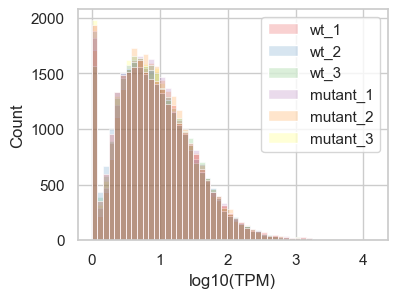

In [5]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot()

sns.histplot(data=log_tpm, bins=50, alpha=0.2)

ax.set_xlabel('log10(TPM)')

さすがはseaborn、１行でサンプルごとに色分けされたヒストグラムが作成された。  
しかしここで疑問が生じる。これまでは色分けをする際にhueを指定した。今回はhueを指定していないのになぜサンプルごとに色分けがされているのだろうか？  

この現象の原因は、データフレームの２つの型にある。

<img src="sources/long_wide_data.png" width=700 alt="LongForm-WideForm">

seabornでは、入力されたデータの内容から自動的に上記２つのいずれの型かを判別する。  
Wide-formデータだと判断した場合には、各列を各グループと判断し、いいように色分けしてくれる。

## 6 サンプルの TPM のヒストグラムを上下にずらして表示 (ridge plot / joyplot)
FacetGrid関数を応用して、複数のグラフを重ねつつ表示してみる。  
以下のコードはseabornホームページのGalleryのコードを改変した。自分の作りたいグラフと似たサンプルコードを見つけたらchatGPTに「このコードを解説してください」など投げてみるといい。  
ridgeplotのサンプルコード：https://seaborn.pydata.org/examples/kde_ridgeplot.html　　　

なお、joyplotをもっと簡単に作成するための、matplotlibのラッパーライブラリ「joypy」も便利。

In [6]:
# この解析ではlong-formのデータが必要になる。
log_tpm_long = log_tpm.melt(var_name='sample', value_name='log_tpm')
log_tpm_long

,sample,log_tpm
0,wt_1,3.582990
1,wt_1,3.445726
2,wt_1,3.738362
3,wt_1,3.611952
4,wt_1,3.538924
...,...,...
160777,mutant_3,1.015543
160778,mutant_3,1.030128
160779,mutant_3,1.096632
160780,mutant_3,1.145214


/Users/mkurokawa/miniforge3/envs/pags2023/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/mkurokawa/miniforge3/envs/pags2023/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/mkurokawa/miniforge3/envs/pags2023/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


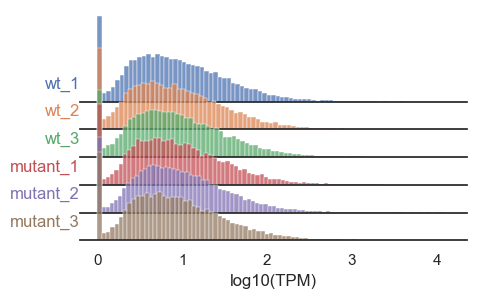

In [7]:
# 詳細は巻末に記載 ->　4.1.
# グラフが重なっても見た目が綺麗になるように設定。
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

# FacetGridオブジェクトを作成
g = sns.FacetGrid(log_tpm_long, row='sample', hue='sample', aspect=10, height=0.5)
g.map(sns.histplot, 'log_tpm')

# 各グラフにラベルを追加するlabel関数を作成し、サンプル名をラベルとして追加する。
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.2, label, color=color, ha='right', va='center', transform=ax.transAxes)
g.map(label, 'sample')

# Facet間の高さを-70%にすることでグラフを重ねる。
g.figure.subplots_adjust(hspace=-0.7)

# 軸の書式設定
g.set_titles('')
g.set(yticks=[], ylabel='')
g.set_xlabels('log10(TPM)')
g.despine(left=True)

In [8]:
# 設定をもとに戻しておく
sns.set_style('whitegrid') 
sns.set_palette('Set1')

## 1.3. MAプロット (散布図)

MAプロットとは、遺伝子ごとの発現量について、実験群間でのログ比（M）、平均発現量（A）を概観できるグラフのこと。  
ここでは、発現変動遺伝子（DEGs）の色をハイライトして表示する。

log2FCの絶対値 > 2のデータを発現変動遺伝子とする。  
log2FC = log2(wt/mutant) = log2(wt) - log2(mutant)

In [9]:
# wtとmutantごとの平均値の対数を取る
wt_log2_tpm_mean=np.log2((tpm['wt_1'] + tpm['wt_2'] + tpm['wt_3']) / 3 + 1.0)
mutant_log2_tpm_mean=np.log2((tpm['mutant_1'] + tpm['mutant_2'] + tpm['mutant_3']) / 3  + 1.0)

# 平均（mu）とfold-change(fc)を計算
mu = (wt_log2_tpm_mean + mutant_log2_tpm_mean) / 2
fc = wt_log2_tpm_mean - mutant_log2_tpm_mean

# fcの絶対値が2よりも大きければTrue, それ以外ならばFalse
is_DEG = np.array([False] * len(fc))
is_DEG[(np.abs(fc) > 2)] = True

# 一つのデータフレームにまとめる
df_MA = pd.DataFrame({'mean_log_tpm': mu, 'fold_change': fc, 'is_DEG': is_DEG})
df_MA.head()

,mean_log_tpm,fold_change,is_DEG
transcript_id,,,
ENSMUST00000082392.1,12.237128,0.095485,False
ENSMUST00000082396.1,11.696890,0.061826,False
ENSMUST00000082402.1,13.025728,-0.126263,False
ENSMUST00000082405.1,12.346719,0.159254,False
ENSMUST00000082407.1,12.165695,-0.059509,False


Text(0, 0.5, 'log2 fold changes (wildtype - mutant)')

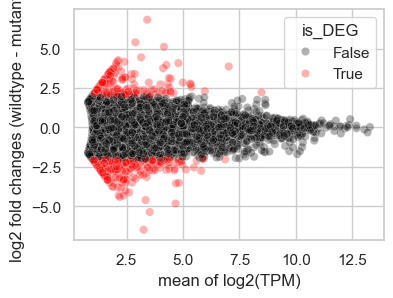

In [10]:
# MAplot (scatter plot)を描画
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot()

sns.scatterplot(data=df_MA, x="mean_log_tpm", y="fold_change", hue="is_DEG", alpha = 0.3, palette=['black', 'red'])
ax.set_xlabel('mean of log2(TPM)')
ax.set_ylabel('log2 fold changes (wildtype - mutant)')

# 2. 複数のグラフを一度に並べて作る関数
これまでみてきた通り、SeabornではMatplotlibだと複雑なコードが必要なグラフを非常にシンプルなコードで書くことができる。  
さらにSeabornには、複数の種類のグラフを綺麗に並べながら配置してくれる独自の関数が３つある。
* jointplot()
* pairplot()
* clustermap()

## 2.1. jointplot()
jointplot()は、散布図とヒストグラムを並べて表示してくれる関数。  
ここでは、wtとmutantの発現量（log2tpm）をjointplotで図示してみる。

なお、よりカスタマイズ性の高いjointGrid()関数を使うと、より多様なグラフの組み合わせができる。

In [11]:
# wt,mutantの平均発現量の対数を取って、データフレームにしておく
wt_log2_tpm_mean=np.log2((tpm['wt_1'] + tpm['wt_2'] + tpm['wt_3']) / 3 + 1.0)
mutant_log2_tpm_mean=np.log2((tpm['mutant_1'] + tpm['mutant_2'] + tpm['mutant_3']) / 3  + 1.0)

log2_tpm_mean = pd.DataFrame({'wt' : wt_log2_tpm_mean, 'mutant' : mutant_log2_tpm_mean})
log2_tpm_mean.head()

,wt,mutant
transcript_id,,
ENSMUST00000082392.1,12.284870,12.189385
ENSMUST00000082396.1,11.727803,11.665977
ENSMUST00000082402.1,12.962597,13.088860
ENSMUST00000082405.1,12.426346,12.267092
ENSMUST00000082407.1,12.135940,12.195449


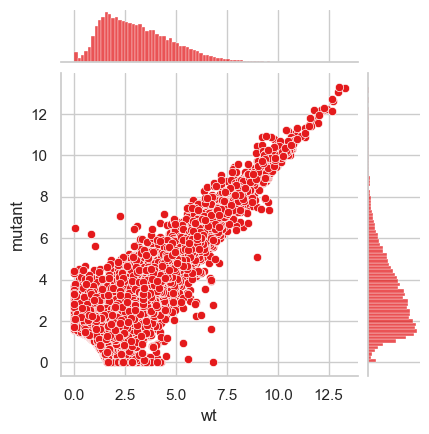

In [16]:
# kindオプションで散布図以外のグラフも指定できる　{ 'scatter', 'kde', 'hist', 'hex', 'reg', 'resid' }
sns.jointplot(x='wt', y='mutant', data=log2_tpm_mean, height=4.5, kind = 'scatter')

## 2.2. pairplot()
pairplot()は各変数の組み合わせで散布図を作ってくれる関数。  
ここでは、6サンプルのTPMを総当たりでヒストグラム付き散布図に描画する。

In [17]:
# 使用データの確認
log_tpm.head()

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
transcript_id,,,,,,
ENSMUST00000082392.1,3.582990,3.845011,3.617391,3.575357,3.535606,3.833645
ENSMUST00000082396.1,3.445726,3.689224,3.397132,3.369460,3.392120,3.693753
ENSMUST00000082402.1,3.738362,4.070999,3.825834,3.857352,3.885274,4.051481
ENSMUST00000082405.1,3.611952,3.935782,3.579248,3.400582,3.564442,3.934689
ENSMUST00000082407.1,3.538924,3.815784,3.544101,3.509200,3.511104,3.880619


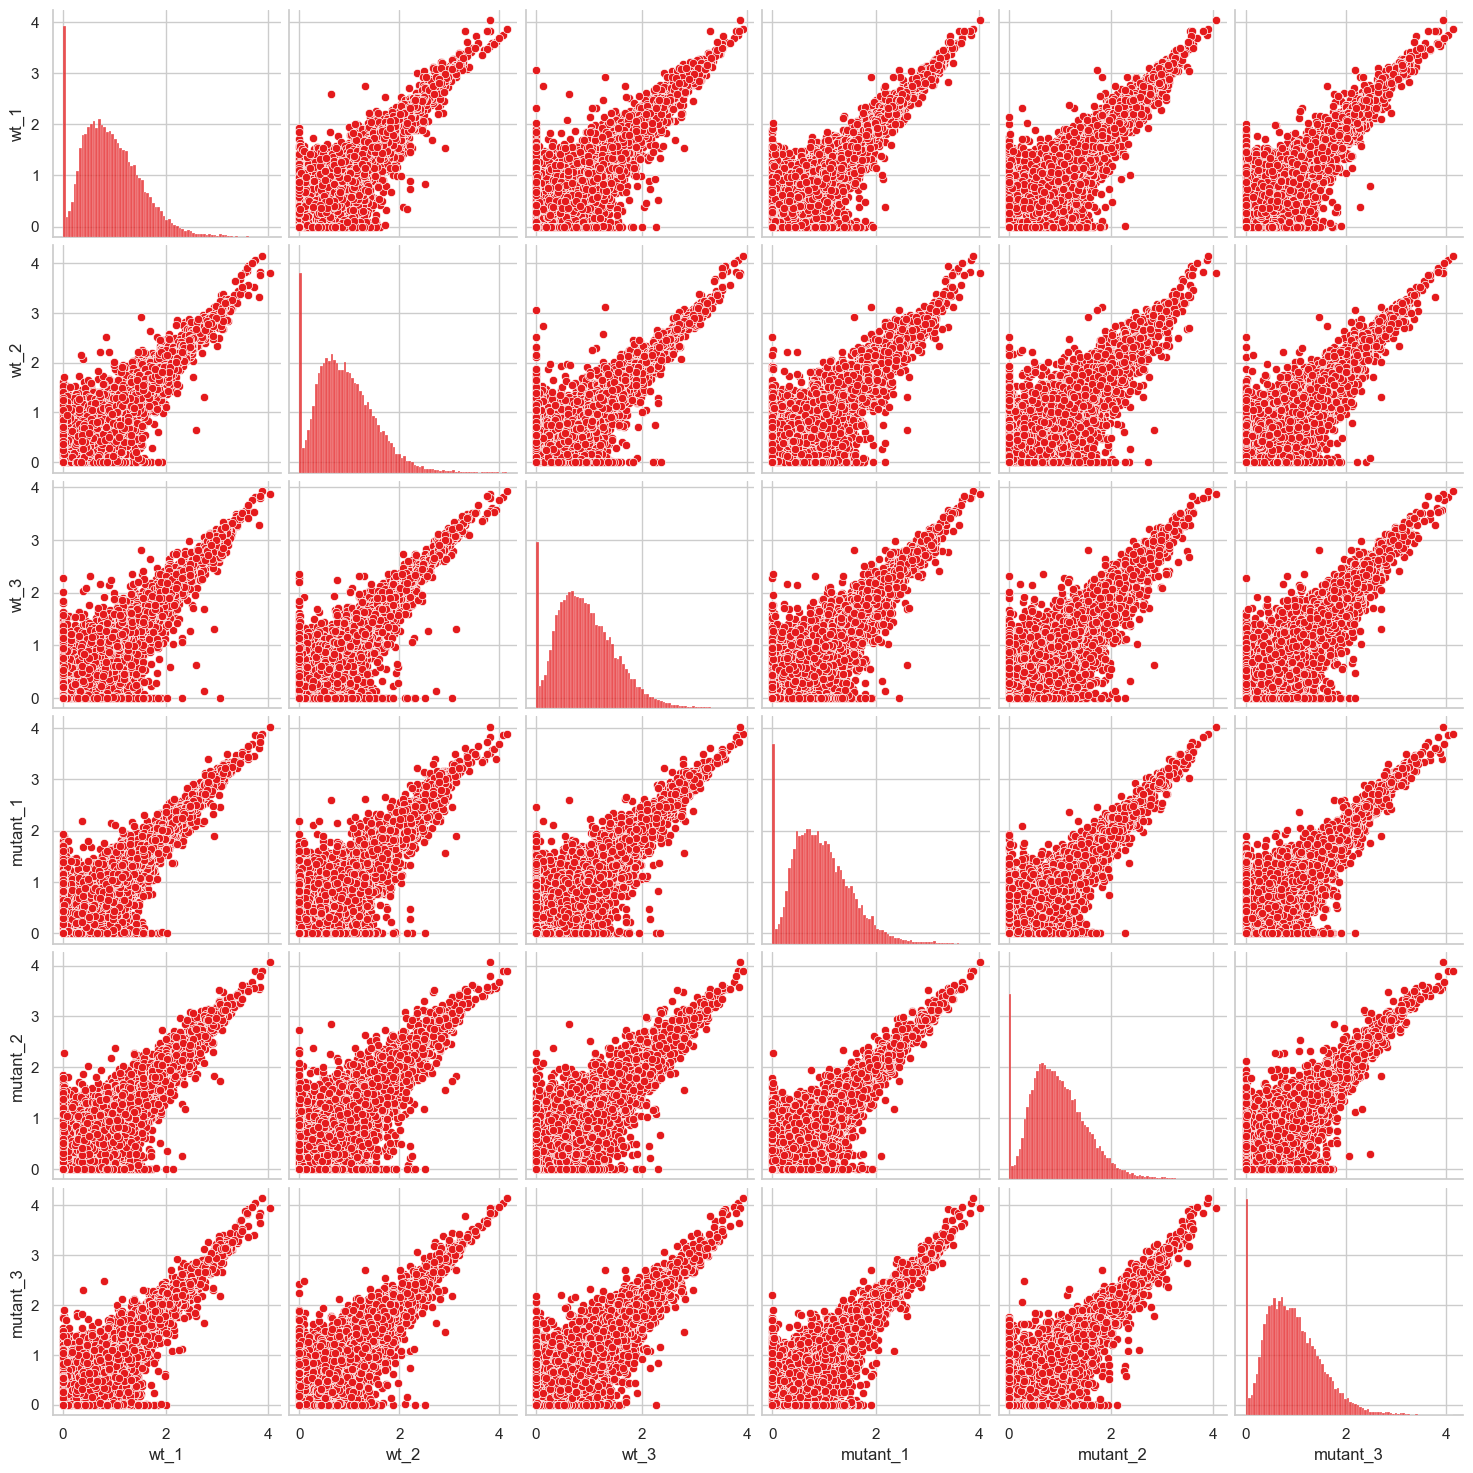

In [18]:
# diag_kindオプションで対角線上のグラフの種類を指定 {'auto', 'hist', 'kde', None}
sns.pairplot(log_tpm, diag_kind='hist')

## 2.3. clustermap()
clustermap()はヒートマップとデンドログラムを同時に表示してくれる関数。  
ここでは、DEGsを抽出して、発現量を可視化してみる。

In [19]:
# 上で作成した'is_DEG' arrayを使って、log10tpmのマトリクスからDEGsのみを抽出する
log_tpm_DEG = log_tpm.loc[is_DEG, :]
log_tpm_DEG

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
transcript_id,,,,,,
ENSMUST00000180008.2,1.211383e+00,1.194700e+00,0.000000,0.000000,0.000000,0.000000
ENSMUST00000020926.8,1.395363e+00,8.862621e-01,0.940021,1.623642,1.712287,1.876188
ENSMUST00000221405.2,1.109633e+00,4.038445e-01,0.921588,1.525177,1.525790,1.621747
ENSMUST00000127568.8,0.000000e+00,0.000000e+00,2.277661,0.000000,1.086440,0.000001
ENSMUST00000039516.4,9.511393e-01,7.674826e-01,0.794083,1.678887,1.559510,0.790534
...,...,...,...,...,...,...
ENSMUST00000133661.8,1.731050e-01,5.122228e-01,0.467723,0.848400,1.225291,1.064920
ENSMUST00000201969.4,0.000000e+00,0.000000e+00,0.276538,0.709684,0.968208,0.632860
ENSMUST00000100089.3,1.546591e+00,4.786937e-01,0.550583,1.887945,2.004444,1.937839


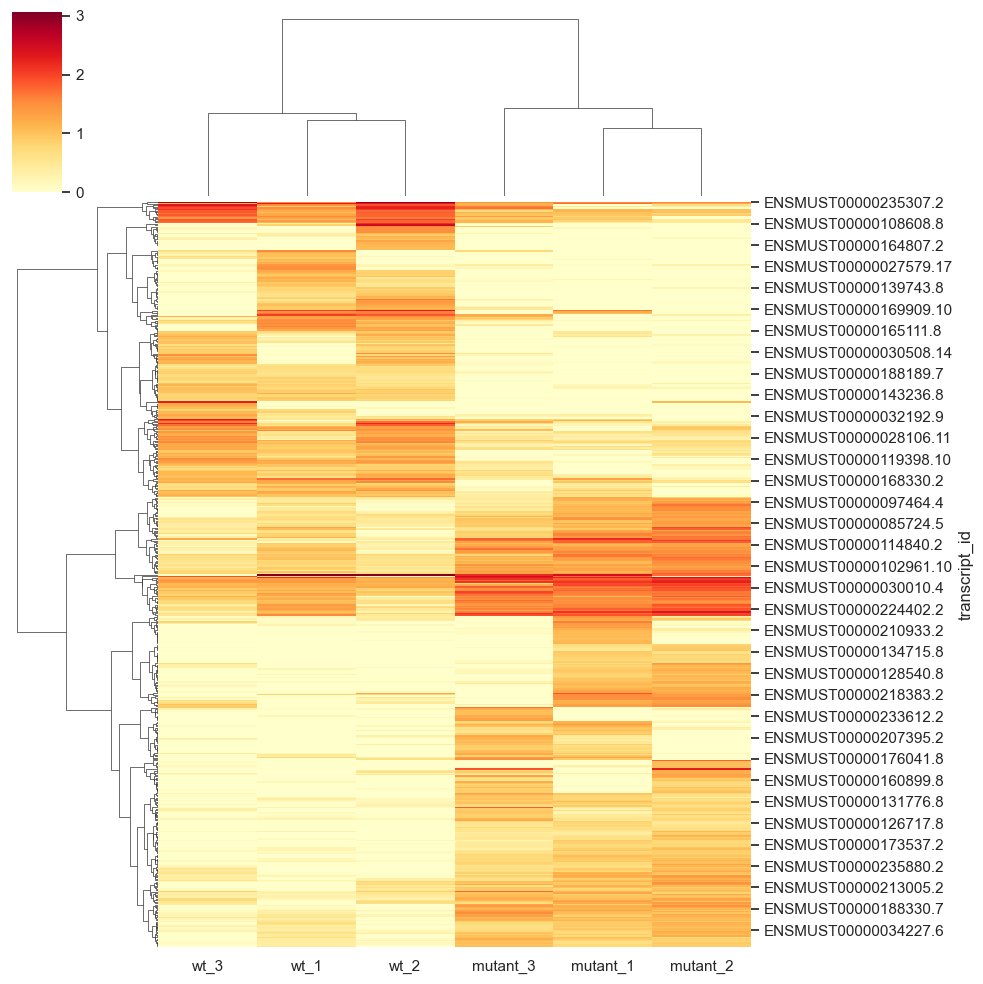

In [20]:
# methodでクラスタリング方法、metricで距離の定義を指定する。
sns.clustermap(log_tpm_DEG, method='ward', metric='euclidean', cmap='YlOrRd', )

## 3. ベン図  
matplotやseabornにはベン図を作成する関数は用意されていない。そこで、matplotlib_vennライブラリを使用する。  

## 3.1. 2円のベン図
「wtの高発現遺伝子」と「mutantの高発現遺伝子」をベン図で表示してみる。  
ベン図を作るために、各円で表示したい要素の集合をset型で用意する。（ここでは、遺伝子のリストを作って、set()関数で型を変更してから渡す）

In [24]:
# 元となるデータ（jointplotで使ったもの）
log2_tpm_mean.head()

,wt,mutant
transcript_id,,
ENSMUST00000082392.1,12.284870,12.189385
ENSMUST00000082396.1,11.727803,11.665977
ENSMUST00000082402.1,12.962597,13.088860
ENSMUST00000082405.1,12.426346,12.267092
ENSMUST00000082407.1,12.135940,12.195449


In [21]:
# wtとmutantのそれぞれで高発現している遺伝子のリストを取得。（5という数値は適当に設定した）
genes_wt = log2_tpm_mean[log2_tpm_mean['wt'] >= 5].index.tolist()
genes_mutant = log2_tpm_mean[log2_tpm_mean['mutant'] >= 5].index.tolist()

#　高発現遺伝子の行の行名を要素とするリストが作られた
print('wtで高発現：', len(genes_wt))
print('リストの頭３要素：', genes_wt[:3])
print('mutantで高発現：', len(genes_mutant))
print('リストの頭３要素：', genes_mutant[:3])

wtで高発現： 4215
リストの頭３要素： ['ENSMUST00000082392.1', 'ENSMUST00000082396.1', 'ENSMUST00000082402.1']
mutantで高発現： 4172
リストの頭３要素： ['ENSMUST00000082392.1', 'ENSMUST00000082396.1', 'ENSMUST00000082402.1']


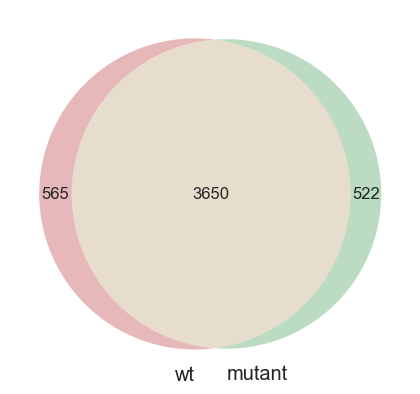

In [27]:
# 2円のベン図にはvenn2関数を使う。先ほど作成したリストをset型にし、それをリストにしたものを渡す。
from matplotlib_venn import venn2

venn2([set(genes_wt), set(genes_mutant)], set_labels = ('wt', 'mutant'))

## 3.2. 3円のベン図
3円の場合には、venn3関数を使う。  
wtの高発現遺伝子、mutantの高発現遺伝子、に加えて発現変動遺伝子(DEGs)をベン図で表してみる。

DEGs： 522
リストの頭３要素： ['ENSMUST00000180008.2', 'ENSMUST00000020926.8', 'ENSMUST00000221405.2']


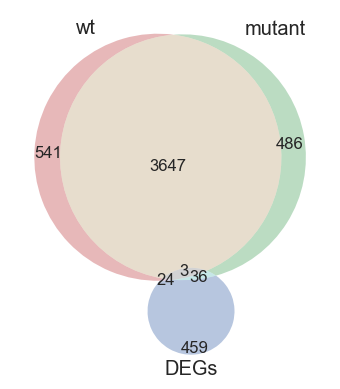

In [26]:
from matplotlib_venn import venn3

# DEGsの遺伝子のリストを取得する
DEGs = log_tpm_DEG.index.tolist()
print('DEGs：', len(DEGs))
print('リストの頭３要素：', DEGs[:3])

# venn2と使い方は一緒。
v = venn3([set(genes_wt), set(genes_mutant), set(DEGs)], set_labels=('wt','mutant', 'DEGs'))

# 4. 説明しなかった部分の説明

## 4.1. FacetGridを使って、Joyplotを作成する
FacetGridの使い方の詳細はSeaborn公式ホームページを参照：
https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

In [ ]:
# グラフが重なっても見た目が綺麗になるように設定。
## axesの背景色設定では、rgba(red, green, blue, alpha)を指定して透明にしている。alpha=0は透明。
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

# FacetGridオブジェクトを作成
## row='sample'と指定することで、sampleごとに行方向（縦方向）にグラフを並べる。
## aspectはグラフの縦横比、heightはグラフの高さ
## FacetGridオブジェクトを作って、gに代入（リンクを貼る）という操作をしている。
g = sns.FacetGrid(log_tpm_long, row='sample', hue='sample', aspect=10, height=0.5)

# それぞれのFacetにヒストグラムを追加する
## mapはFacetGridで作られた各Axesオブジェクトに対して、第１引数で指定した関数を実行するメソッド
## ここでは各Facet（のAxes）にlog_tpmのヒストグラムをマップする、という操作。
g.map(sns.histplot, 'log_tpm')

# 各グラフにラベルを追加するlabel関数を定義する
## mapメソッドの第一引数にくる関数は、colorとlabelをオプションとして持つ必要がある。
def label(x, color, label):
    # axは現在のAxesとする。こうすることで、FacetGridで作られた各Axesに対して一つづつ関数を実行できる。
    ax = plt.gca()
    # textをx座標=0, y座標=20%の位置、colorはseabornで自動的に割り振られたcolor、ha/vaでtextの右端・高さ中心が指定の位置に来るように調整、transformで各Axesの中の指定の位置（x=0,y=20%）に対して位置合わせするように指定。
    ax.text(0, 0.2, label, color=color, ha='right', va='center', transform=ax.transAxes)
# sample列のデータに対してlabel関数を適用する。sample列の文字列が上で定義された位置に表示される。
g.map(label, 'sample')

# Facet間の高さを-70%にすることでグラフを重ねる。
g.figure.subplots_adjust(hspace=-0.7)

# 軸の書式設定
g.set_titles('')
g.set(yticks=[], ylabel='')
g.set_xlabels('log10(TPM)')
g.despine(left=True)